In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline  # Use imblearn's Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('brainstrokeML.csv')

In [5]:
df

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
0,67.0,0,1,228.69,36.6,formerly smoked,1
1,80.0,0,1,105.92,32.5,never smoked,1
2,49.0,0,0,171.23,34.4,smokes,1
3,79.0,1,0,174.12,24.0,never smoked,1
4,81.0,0,0,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...
4976,41.0,0,0,70.15,29.8,formerly smoked,0
4977,40.0,0,0,191.15,31.1,smokes,0
4978,45.0,1,0,95.02,31.8,smokes,0
4979,40.0,0,0,83.94,30.0,smokes,0


In [7]:
X = df.drop('stroke', axis=1)
y = df['stroke']

In [9]:
categorical_features = ['smoking_status']
numeric_features = ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [13]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [17]:
smote = SMOTE(random_state=42)

# LogisticRegression

In [20]:
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

In [22]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('smote', smote),
                           ('classifier', logreg)])

In [24]:
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2']  # Using L1 and L2 regularization
}

In [26]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi',
                                                                          'hypertension',
                                                                          'heart_disease']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['smoking_status'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           solver='liblinear'))]),
             param_grid={'classifier__C': [0.1, 1, 10],
                         'classifier__penalty': ['l1', 'l2']},
             scoring='roc_auc')

In [27]:
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]


In [28]:
print(classification_report(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      1421
           1       0.14      0.77      0.24        74

    accuracy                           0.75      1495
   macro avg       0.56      0.76      0.54      1495
weighted avg       0.94      0.75      0.82      1495

ROC AUC Score: 0.8476044658310669


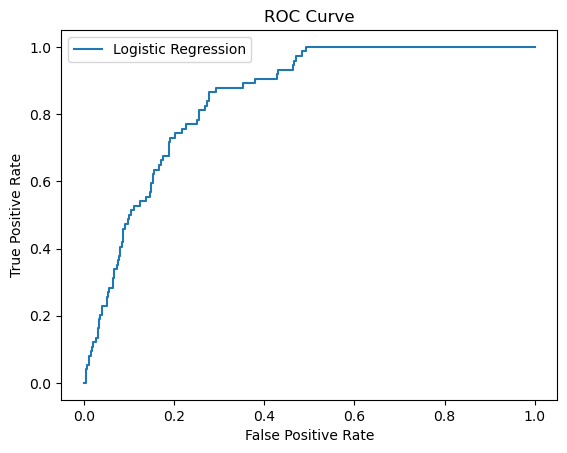

In [32]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# KNN

In [35]:
from sklearn.neighbors import KNeighborsClassifier

In [37]:
knn = KNeighborsClassifier()

In [39]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('smote', SMOTE(random_state=42)),  # Apply SMOTE here
                           ('classifier', knn)])

In [40]:
param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9],         # Different values for neighbors
    'classifier__weights': ['uniform', 'distance'],  # Uniform vs. distance-based weighting
    'classifier__metric': ['euclidean', 'manhattan', 'minkowski']  # Different distance metrics
}

In [41]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi',
                                                                          'hypertension',
                                                                          'heart_disease']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['smoking_status'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__metric': ['euclidean', 'manhattan',
                                                'minkowski'],
                         'classifier__n_neighbors': [3, 5, 7, 9],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [44]:
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

In [45]:
print("Best hyperparameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))

Best hyperparameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 9, 'classifier__weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.97      0.80      0.88      1421
           1       0.13      0.59      0.22        74

    accuracy                           0.79      1495
   macro avg       0.55      0.70      0.55      1495
weighted avg       0.93      0.79      0.84      1495

ROC AUC Score: 0.7376609544097228


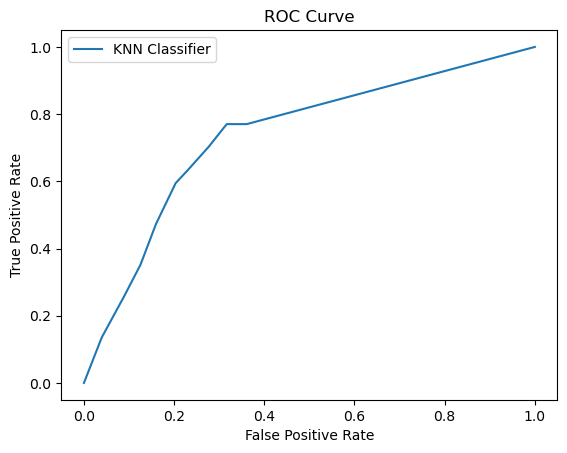

In [46]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="KNN Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# SVM

In [48]:
from sklearn.svm import SVC

In [49]:
svm = SVC(probability=True)

In [50]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('smote', SMOTE(random_state=42)),  # Apply SMOTE here
                           ('classifier', svm)])

In [51]:
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],               # Regularization parameter
    'classifier__kernel': ['linear', 'rbf', 'poly'],  # Different kernels
    'classifier__gamma': ['scale', 'auto'],           # Kernel coefficient for 'rbf' and 'poly'
}

In [52]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi',
                                                                          'hypertension',
                                                                          'heart_disease']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['smoking_status'])])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier', SVC(probability=True))]),
             param_grid={'classifier__C': [0.1, 1, 10, 100],
                         'classifier__gamma': ['scale', 'auto'],
                         'classifier__kernel': ['linear', 'rbf', 'poly']},
             scoring='roc_auc')

In [53]:
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

In [54]:
print("Best hyperparameters:", grid_search.best_params_)
print(classification_report(y_test, y_pred))
print('ROC AUC Score:', roc_auc_score(y_test, y_pred_proba))

Best hyperparameters: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.99      0.74      0.85      1421
           1       0.14      0.81      0.24        74

    accuracy                           0.74      1495
   macro avg       0.56      0.77      0.54      1495
weighted avg       0.94      0.74      0.82      1495

ROC AUC Score: 0.847124217813873


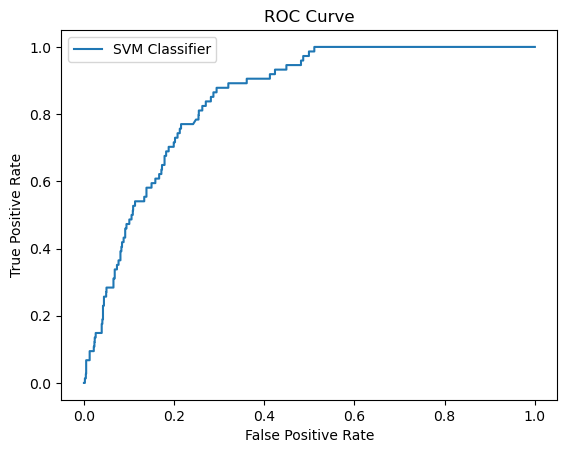

In [55]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="SVM Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()